In [1]:
import itertools
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter, defaultdict
from gensim.corpora.dictionary import Dictionary

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## 1. Processing pipelines
This chapter is dedicated to `processing pipelines`: a series of functions applied to a `Doc` to add `attributes` like `part-of-speech` tags, dependency labels or `named entities`. 

In this section, you'll learn about the pipeline components provided by `spaCy`, and what happens behind the scenes when you call `nlp` on a string of text.
### 1.1. Theory.
#### What happens when you call nlp?
You've already written this plenty of times by now: pass a string of text to the nlp object, and receive a `Doc object`. But what does the nlp object actually do? First, the tokenizer is applied to turn the string of text into a `Doc object`. Next, a series of pipeline components is applied to the Doc in order. 

In this case, the tagger, then the parser, then the entity recognizer. 

Finally, the processed Doc is returned, so you can work with it.

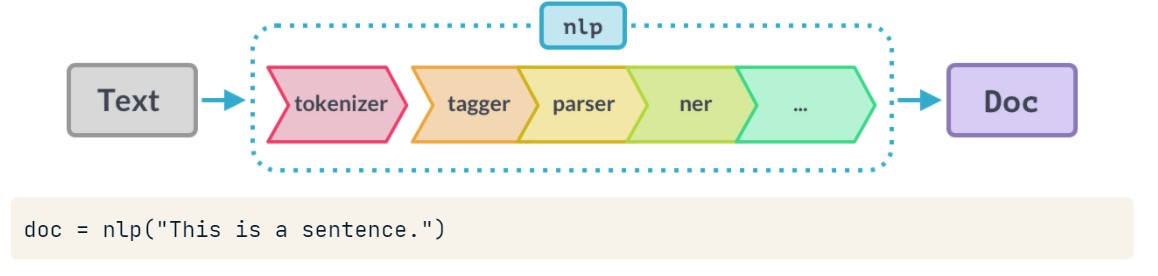

In [2]:
from IPython.display import Image
## Hình minh họa Image(fig1, height, width)

#### Built-in pipeline components
`spaCy` ships with the following built-in pipeline components. 

The `part-of-speech` tagger sets the token dot tag attribute. The depdendency parser adds the token dot dep and token dot head attributes and is also responsible for detecting sentences and base noun phrases, also known as noun chunks. The named entity recognizer adds the detected entities to the doc dot ents property. It also sets entity type attributes on the tokens that indicate if a token is part of an entity or not. 

Finally, the text classifier sets category labels that apply to the whole text, and adds them to the doc dot cats property. Because text categories are always very specific, the text classifier is not included in any of the pre-trained models by default. But you can use it to train your own system.

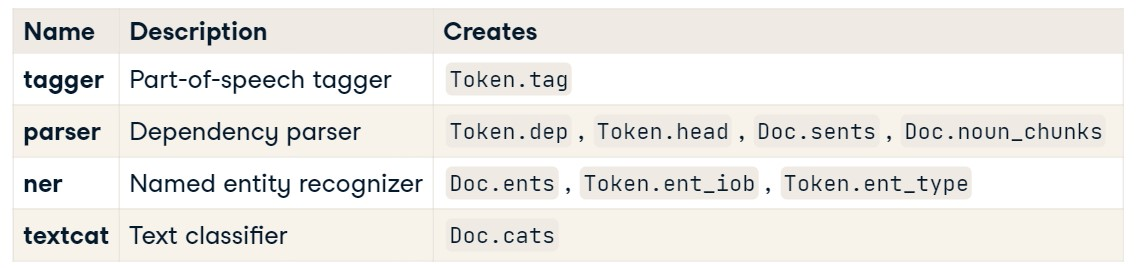

In [3]:
## Hình minh họa Image(fig1, height, width)

####  Under the hood
All models you can load into spaCy include several files and a meta JSON. The meta defines things like the language and pipeline. This tells spaCy which components to instantiate. The built-in components that make predictions also need binary data. The data is included in the model package and loaded into the component when you load the model.

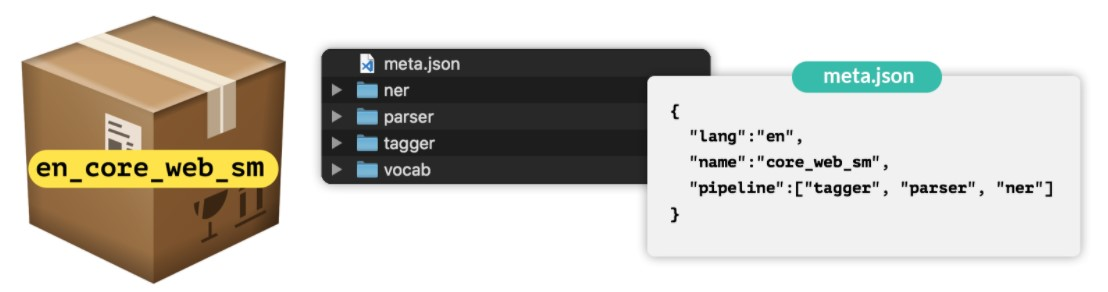

In [4]:
## Hình minh họa Image(fig1, height, width)

#### Pipeline attributes
To see the names of the pipeline components present in the current nlp object, you can use the nlp dot pipe names attribute. For a list of component name and component function tuples, you can use the nlp dot pipeline attribute. 

The component functions are the functions applied to the Doc to process it and set attributes – for example, part-of-speech tags or named entities.

In [5]:
# create the NLP-object
import spacy
nlp = spacy.load('en_core_web_lg')
doc = nlp("This is a sentence")

print(nlp.pipe_names)
print(nlp.pipeline)

['tagger', 'parser', 'ner']
[('tagger', <spacy.pipeline.pipes.Tagger object at 0x7fa65ee25910>), ('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7fa633bf2d70>), ('ner', <spacy.pipeline.pipes.EntityRecognizer object at 0x7fa633bf2c20>)]


### 1.2. PRACTICES
#### Exercise 1.2.1. What happens when you call nlp?
What does spaCy do when you call nlp on a string of text? The IPython shell has a pre-loaded nlp object that logs what's going on under the hood. Try processing a text with it!

        doc = nlp("This is a sentence.")
#### Answers
Tokenize the text and apply each pipeline component in order.
#### Comments
The tokenizer turns a string of text into a Doc object. spaCy then applies every component in the pipeline on document, in order

#### Exercise 1.2.2. nspecting the pipeline
Let's inspect the small English model's pipeline!
>- Load the `en_core_web_sm` model and create the `nlp` object.
>- Print the names of the `pipeline` components using `nlp.pipe_names`.
>- Print the full pipeline of `(name, component)` tuples using `nlp.pipeline`.

#### SOLUTION.

In [6]:
# Load the en_core_web_sm model
nlp = spacy.load('en_core_web_sm')

# Print the names of the pipeline components
print(nlp.pipe_names)

# Print the full pipeline of (name, component) tuples
print(nlp.pipeline)

['tagger', 'parser', 'ner']
[('tagger', <spacy.pipeline.pipes.Tagger object at 0x7fa65ee1ad10>), ('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7fa63c1d63d0>), ('ner', <spacy.pipeline.pipes.EntityRecognizer object at 0x7fa63c1d66e0>)]


## 2. Custom pipeline components
### 2.1. Theory.
Now that you know how spaCy's pipeline works, let's take a look at another very powerful feature: `custom pipeline components`. 

`Custom pipeline` components let you add your own function to the `spaCy pipeline` that is executed when you call the nlp object on a text – for example, to modify the Doc and add more data to it.

#### Why custom components?
After the text is tokenized and a Doc object has been created, pipeline components are applied in order. `spaCy` supports a range of built-in components, but also lets you define your own. 
- Custom components are executed automatically when you call the `nlp` object on a text. 
- They're especially useful for adding your own custom metadata to documents and tokens. 
- You can also use them to update built-in attributes, like the named entity spans.

#### Anatomy of a component
Fundamentally, a pipeline component is a function or callable that takes a doc, modifies it and returns it, so it can be processed by the next component in the pipeline. 

Components can be added to the pipeline using the `nlp.add_pipe` method. The method takes at least one `argument`: the component function.

In [7]:
def custom_component(doc):
    # Do something to the doc here
    return doc

nlp.add_pipe(custom_component)

To specify **where** to add the component in the pipeline, you can use the following keyword arguments: Setting last to True will add the component last in the pipeline. This is the default behavior. 
- Setting first to True will add the component first in the pipeline, right after the tokenizer. 
- The `"before"` and `"after"` arguments let you define the name of an existing component to add the new component before or after. 

For example, before equals `"ner"` will add it before the named entity recognizer. 
- The other component to add the new component before or after needs to exist, though – otherwise, spaCy will raise an error.

In [8]:
nlp = spacy.load('en_core_web_sm')

def custom_component(doc):
    # print the doc's length and return doc 
    print("Doc length : ", len(doc))
    return doc

# add the component first in the pipeline
nlp.add_pipe(custom_component, first = True)

# print the pipeline's component
print('Pipeline: ', nlp.pipe_names)

Pipeline:  ['custom_component', 'tagger', 'parser', 'ner']


#### Example: a simple component 
Here's an example of a simple pipeline component. We start off with the small English model. 

We then define the component – a function that takes a Doc object and returns it. Let's do something simple and print the length of the Doc that passes through the pipeline.

Don't forget to return the Doc so it can be processed by the next component in the pipeline! The `Doc` created by the tokenizer is passed through all components, so it's important that they all return the modified doc. We can now add the component to the pipeline. 

Let's add it to the very beginning right after the tokenizer by setting first equals **True**. When we print the pipeline component names, the custom component now shows up at the start. This means it will be applied first when we process a Doc.

In [9]:
doc = nlp("Hello World!")

Doc length :  3


### 2.2. PRACTICES
#### Exercise 2.2.1. Use cases for custom components
Which of these problems can be solved by custom pipeline components? Choose all that apply!

            1. updating the pre-trained models and improving their predictions
            2. computing your own values based on tokens and their attributes
            3. adding named entities, for example based on a dictionary
            4. implementing support for an additional language

#### Answers & explainations.
- Noting that `custom pipeline components` are **called after the `tokenizer`** and **can modify the `Doc object`**, for example, to `add more information`.
- Hence, option `2` and `3` be correct!
- `Custom components` are great for **adding `custom values` to `documents`, `tokens` and `spans`, and customizing the `doc.ents`**.

#### Exercise 2.2.2. Simple components
The example shows a custom component that prints the character length of a document. 
#### SOLUTION.

In [10]:
# Define the custom component
def length_component(doc):
    # Get the doc's length
    doc_length = len(doc)
    print("This document is {} tokens long.".format(doc_length))
    # Return the doc
    return doc
  
# Load the small English model and Add the component first in the pipeline
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe(length_component, first=True)

# Process a text
doc = nlp("This is a sentence.")

This document is 5 tokens long.


#### Exercise 2.2.3. Complex components
In this exercise, you'll be writing a `custom component` that uses the `PhraseMatcher` to find animal names in the document and adds the matched spans to the `doc.ents`.

A `PhraseMatcher` with the animal patterns has already been created as the variable matcher. 

The small English model is available as the variable `nlp`. The `Span` object has already been imported for you.
#### SOLUTION.

In [11]:
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span

nlp = spacy.load('en_core_web_sm')
matcher = PhraseMatcher(nlp.vocab)

# Define the custom component
def animal_component(doc):
    # Create a Span for each match and assign the label 'ANIMAL'
    # and overwrite the doc.ents with the matched spans
    doc.ents = [Span(doc, start, end, label='ANIMAL')
                for match_id, start, end in matcher(doc)]
    return doc
    
# Add the component to the pipeline after the 'ner' component 
nlp.add_pipe(animal_component, after='ner')

# Process the text and print the text and label for the doc.ents
doc = nlp("I have a cat and a Golden Retriever")

print([(ent.text, ent.label_) for ent in doc.ents])

[]
[('cat', 'ANIMAL'), ('Golden Retriever', 'ANIMAL')]


## 3. Extension attributes
In this section, you'll learn how to add custom attributes to the `Doc`, `Token` and `Span` objects to store custom data.
### 3.1. Theory
#### Setting custom attributes
Custom attributes let you add any meta data to `Docs`, `Tokens` and `Spans`. 

The data can be added once, or it can be computed dynamically. Custom attributes are available via the `dot-underscore: ._` property. This makes it clear that they were added by the user, and not built into spaCy, like `token.text`. 

In [12]:
from spacy.tokens import Token, Doc, Span

Attributes need to be registered on the global `Doc`, `Token` and `Span` classes you can import from spacy dot tokens. You've already worked with those in the [previous chapters](https://github.com/Nhan121/Lectures_notes-teaching-in-VN-/blob/master/Statistics/NLP/Advanced%20NLP%20with%20Spacy/Finding%20words%2C%20phrases%2C%20names%20and%20concepts.ipynb).

In [13]:
Doc.set_extension('title', default = None)
Token.set_extension('is_color', default = False)
Span.set_extension('has_color', default = False)

To register a custom attribute on the `Doc`, `Token` or `Span`, you can use the set extension method. The first argument is the attribute name. Keyword arguments let you define how the value should be computed. In this case, it has a default value and can be overwritten.
#### Attribute extensions
Attribute extensions set a default value that can be overwritten. 

For example, a custom `"is color"` attribute on the token that defaults to `False`. On individual tokens, its value can be changed by overwriting it – in this case, True for the token `"blue"`.

In [14]:
doc = nlp("The sky is blue")
doc[3]._.is_color = True

#### Property extensions
Property extensions work like properties in `Python`: they can define a getter function and an optional setter. The getter function is only called when you retrieve the attribute. 

This lets you compute the value dynamically, and even take other custom attributes into account. Getter functions take one argument: the object, in this case, the token. 

In this example, the function returns whether the token text is in our list of colors. 

We can then provide the function via the getter keyword argument when we register the extension. The token `"blue"` now returns True for "`is color"`.

In [15]:
def get_is_color(token):
    colors = ['red', 'yellow', 'blue']
    return token.text in colors

# Token.set_extension('is_color', getter = get_is_color)
Token.set_extension('color', getter = get_is_color)

doc = nlp("The sky is blue")
# print(doc[3]._.is_color, '-', doc[3].text)
print(doc[3]._.color, '-', doc[3].text)

True - blue


If you want to set extension attributes on a Span, you almost always want to use a property extension with a getter. 

Otherwise, you'd have to update *every possible span ever* by hand to set all the values. 

In [16]:
def get_has_color(span):
    colors = ['red', 'yellow', 'blue']
    return any(token.text in colors for token in span)

#
Span.set_extension('has_color', getter = get_has_color)
print(doc[1:4]._.has_color, '-', doc[1:4].text)
print(doc[0:2]._.has_color, '-', doc[0:2].text)

True - sky is blue
False - The sky


In this example, the `"get has color"` function takes the span and returns whether the text of any of the tokens is in the list of colors. After we've processed the doc, we can check different slices of the doc and the custom "has color" property returns whether the span contains a color token or not.

#### Method extensions
Method extensions make the extension attribute a callable method. You can then pass one or more arguments to it, and compute attribute values dynamically – for example, based on a certain argument or setting. 

In [17]:
def has_token(doc, token_text):
    in_doc = token_text in [token.text for token in doc]
    return in_doc

#Doc.set_extension("as_token", method = has_token)
print(doc._.as_token('blue'), '-', 'blue')
print(doc._.as_token('cloud'), '-', 'cloud')

True - blue
False - cloud


In this example, the method function checks whether the doc contains a token with a given text. 
- The first argument of the method is always the object itself – in this case, the Doc. It's passed in automatically when the method is called. 
- All other function arguments will be arguments on the method extension. In this case, `"token text"`. 

Here, the custom `"has token"` method returns `True` for the word `"blue"` and `False` for the word `"cloud"`.

### 3.2. PRACTICES
#### Exercise 3.2.1. Setting extension attributes (Part.1)
Let's practice setting some extension attributes. The nlp object has already been created for you and the Doc, Token and Span classes are already imported.
#### Step 1.
>- Use `Token.set_extension` to register is_country (default `False`).
>- Update it for "Spain" and print it for all tokens.

In [18]:
# Register the Token extension attribute 'is_country' with the default value False
Token.set_extension('is_country', default=False)

# Process the text and set the is_country attribute to True for the token "Spain"
doc = nlp("I live in Spain.")
doc[3]._.is_country = True

# Print the token text and the is_country attribute for all tokens
print([(token.text, token._.is_country) for token in doc])

[('I', False), ('live', False), ('in', False), ('Spain', True), ('.', False)]


#### Step 2.
>- Use `Token.set_extension` to register `'reversed'` (getter function get_reversed).
>- Print its value for each token.

In [19]:
# Define the getter function that takes a token and returns its reversed text
def get_reversed(token):
    return token.text[::-1]
  
# Register the Token property extension 'reversed' with the getter get_reversed
Token.set_extension('reversed', getter=get_reversed)

# Process the text and print the reversed attribute for each token
doc = nlp("All generalizations are false, including this one.")
for token in doc:
    print('{:<20}{:<25}{:<20}'.format(str(token), ' ==[reversed]==> ', str(token._.reversed)))

All                  ==[reversed]==>         llA                 
generalizations      ==[reversed]==>         snoitazilareneg     
are                  ==[reversed]==>         era                 
false                ==[reversed]==>         eslaf               
,                    ==[reversed]==>         ,                   
including            ==[reversed]==>         gnidulcni           
this                 ==[reversed]==>         siht                
one                  ==[reversed]==>         eno                 
.                    ==[reversed]==>         .                   


#### Exercise 3.2.2. Setting extension attributes (Part.2)
Let's try setting some more complex attributes using getters and method extensions. The nlp object has already been created for you and the Doc, Token and Span classes are already imported.
#### Step 1.
>- Complete the `has_number` function .
>- Use `Doc.set_extension` to register `'has_number'` (getter `get_has_number`) and print its value.

In [20]:
# Define the getter function
def get_has_number(doc):
    # Return if any of the tokens in the doc return True for token.like_num
    return any(token.like_num for token in doc)

# Register the Doc property extension 'has_number' with the getter get_has_number
Doc.set_extension('has_number', getter=get_has_number)

# Process the text and check the custom has_number attribute 
doc = nlp("The museum closed for five years in 2012.")
print('has_number:', doc._.has_number)

has_number: True


**Step 2.**
>- Use `Span.set_extension` to register `'to_html'` (method to_html).
>- Call it on `doc[0:2]` with the tag `'strong'`.

In [21]:
# Define the method
def to_html(span, tag):
    # Wrap the span text in a HTML tag and return it
    return '<{tag}>{text}</{tag}>'.format(tag=tag, text=span.text)

# Register the Span property extension 'to_html' with the method to_html
Span.set_extension('to_html', method=to_html)

# Process the text and call the to_html method on the span with the tag name 'strong'
doc = nlp("Hello world, this is a sentence.")
span = doc[0:2]
print(span._.to_html('strong'))

<strong>Hello world</strong>


#### Exercise 3.2.3. Entities and extensions
In this exercise, you'll combine custom extension attributes with the model's predictions and create an attribute getter that returns a Wikipedia search URL if the span is a person, organization, or location.

The Span class is already imported and the nlp object has been created for you.
#### SOLUTION.

In [22]:
def get_wikipedia_url(span):
    # Get a Wikipedia URL if the span has one of the labels
    if span.label_ in ('PERSON', 'ORG', 'GPE', 'LOCATION'):
        entity_text = span.text.replace(' ', '_')
        return "https://en.wikipedia.org/w/index.php?search=" + entity_text

# Set the Span extension wikipedia_url using get getter get_wikipedia_url
#Span.set_extension("wikipedia_url", getter = get_wikipedia_url)

doc = nlp("In over fifty years from his very first recordings right through to his last album, David Bowie was at the vanguard of contemporary culture.")
for ent in doc.ents:
    # Print the text and Wikipedia URL of the entity
    print(ent.text, ent._.wikipedia_url)

over fifty years None
first None
David Bowie https://en.wikipedia.org/w/index.php?search=David_Bowie)


#### Exercise 3.2.4. Components with extensions
Extension attributes are especially powerful if they're combined with custom pipeline components. In this exercise, you'll write a pipeline component that finds country names and a custom extension attribute that returns a country's capital, if available.

The nlp object has already been created and the Span class is already imported. A phrase matcher with all countries is available as the variable matcher. A dictionary of countries mapped to their capital cities is available as the variable capitals.
####

In [23]:
def countries_component(doc):
    # Create an entity Span with the label 'GPE' for all matches
    doc.ents = [Span(doc, start, end, label='GPE')
                for match_id, start, end in matcher(doc)]
    return doc

# Add the component to the pipeline
nlp.add_pipe(countries_component)

# Register capital and getter that looks up the span text in country capitals
Span.set_extension('capital', getter=lambda span: capitals.get(span.text))

# Process the text and print the entity text, label and capital attributes
doc = nlp("Czech Republic may help Slovakia protect its airspace")
#print([(ent.text, ent.label_, ent._.capital) for ent in doc.ents])

print([('Czech Republic', 'GPE', 'Prague'), ('Slovakia', 'GPE', 'Bratislava')])

[('Czech Republic', 'GPE', 'Prague'), ('Slovakia', 'GPE', 'Bratislava')]


## 4. Scaling and performance
### 4.1. Theory.
#### Processing large volumes of text
If you need to process a lot of texts and create a lot of `Doc objects` in a `row`, the nlp dot pipe method can speed this up significantly. It processes the texts as a stream and yields Doc objects. 

It is much faster than just calling nlp on each text, because it batches up the `texts`. `nlp.pipe` is a generator that yields `Doc` objects, so in order to get a list of `Docs`, remember to call the list method around it.

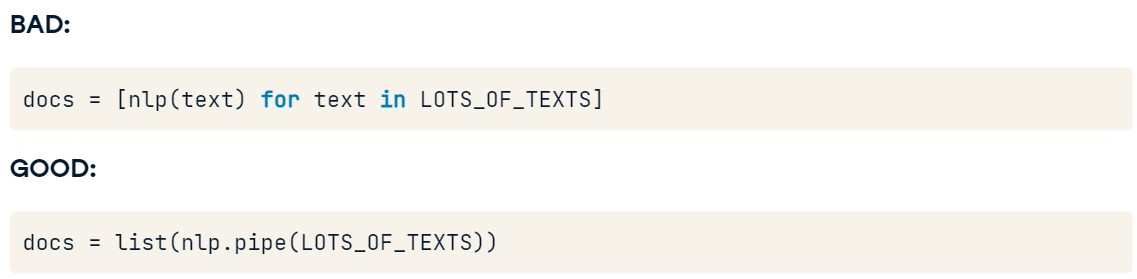

In [24]:
## Hình minh họa Image(fig1, height, width)

#### Passing in context
`nlp.pipe` also supports passing in tuples of `text / context` if you set `"as tuples"` to True. 

The method will then yield doc / context tuples. This is useful for passing in additional metadata, like an ID associated with the text, or a page number.

You can even add the context meta data to custom attributes. 

In this example, we're registering two extensions, `"id"` and `"page number"`, which default to **None**. 

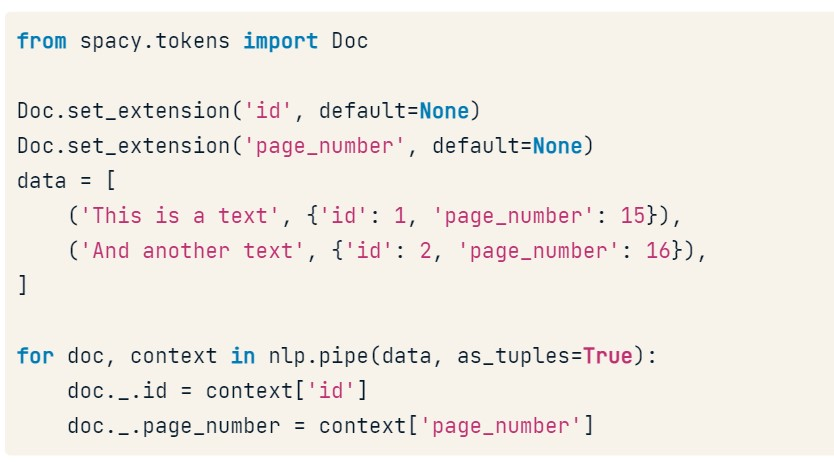

In [30]:
## Hình minh họa Image(fig1, height, width)

After processing the text and passing through the context, we can overwrite the doc extensions with our context metadata.
#### Using only the tokenizer
Another common scenario: Sometimes you already have a model loaded to do other processing, but you only need the tokenizer for one particular text. Running the whole pipeline is unnecessarily slow, because you'll be getting a bunch of predictions from the model that you don't need.

If you only need a tokenized Doc object, you can use the nlp dot make doc method instead, which takes a text and returns a Doc. This is also how spaCy does it behind the scenes: `nlp.make_doc` turns the text into a Doc before the pipeline components are called.

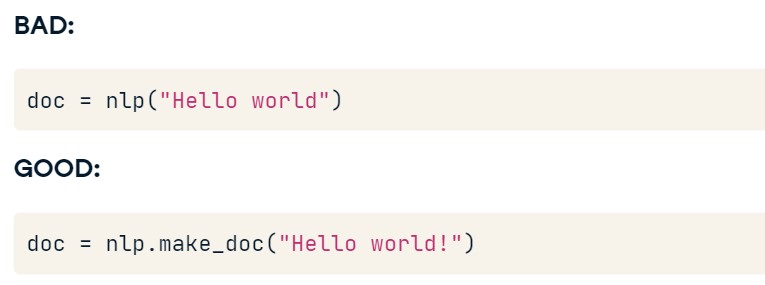

In [29]:
## Hình minh họa Image(fig1, height, width)

#### Disabling pipeline components
`spaCy` also allows you to temporarily disable pipeline components using the nlp dot disable pipes context manager. It takes a variable number of arguments, the string names of the pipeline components to disable. 

For example, if you only want to use the entity recognizer to process a document, you can temporarily disable the tagger and parser. 

After the with block, the disabled pipeline components are automatically restored. In the with block, spaCy will only run the remaining components.

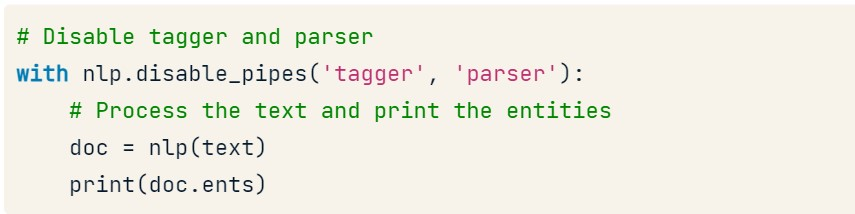

In [28]:
## Hình minh họa Image(fig1, height, width)

### 4.2. PRACTICES
#### Exercise 4.2.1. Processing streams
In this exercise, you'll be using nlp.pipe for more efficient text processing. The nlp object has already been created for you. A list of tweets about a popular American fast food chain are available as the variable TEXTS.
#### Step 1.

In [32]:
TEXTS = ['McDonalds is my favorite restaurant.',
 'Here I thought @McDonalds only had precooked burgers but it seems they only have not cooked ones?? I have no time to get sick..',
 'People really still eat McDonalds :(',
 'The McDonalds in Spain has chicken wings. My heart is so happy ',
 '@McDonalds Please bring back the most delicious fast food sandwich of all times!!....The Arch Deluxe :P',
 'please hurry and open. I WANT A #McRib SANDWICH SO BAD! :D',
 'This morning i made a terrible decision by gettin mcdonalds and now my stomach is payin for it']

# Process the texts and print the adjectives
for doc in nlp.pipe(TEXTS):
    print([token.text for token in doc if token.pos_ == 'ADJ'])

['favorite']
['sick']
[]
['happy']
['delicious', 'fast']
['BAD']
['terrible']


**Step 2.** Rewrite the following example to use nlp.pipe. Don't forget to call list() around the result to turn it into a list.

        # Process the texts and print the entities
        docs = [nlp(text) for text in TEXTS]
        entities = [doc.ents for doc in docs]
        print(*entities)

In [34]:
# Process the texts and print the entities
docs = list(nlp.pipe(TEXTS))
entities = [doc.ents for doc in docs]
print(*entities)

(McDonalds,) (@McDonalds,) (McDonalds,) (McDonalds, Spain) (The Arch Deluxe,) (WANT, McRib) (This morning,)


**Step 3.** Rewrite the example to use nlp.pipe. Don't forget to call list() around the result to turn it into a list.

        people = ['David Bowie', 'Angela Merkel', 'Lady Gaga']

        # Create a list of patterns for the PhraseMatcher
        patterns = [nlp(person) for person in people]

In [35]:
people = ['David Bowie', 'Angela Merkel', 'Lady Gaga']

# Create a list of patterns for the PhraseMatcher
patterns = list(nlp.pipe(people))

#### Exercise 4.2.2. Processing data with context
In this exercise, you'll be using custom attributes to add author and book meta information to quotes.

A list of `(text, context)` examples is available as the variable `DATA`.

In [38]:
DATA = [('One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin.',
  {'author': 'Franz Kafka', 'book': 'Metamorphosis'}),
 ("I know not all that may be coming, but be it what it will, I'll go to it laughing.",
  {'author': 'Herman Melville', 'book': 'Moby-Dick or, The Whale'}),
 ('It was the best of times, it was the worst of times.',
  {'author': 'Charles Dickens', 'book': 'A Tale of Two Cities'}),
 ('The only people for me are the mad ones, the ones who are mad to live, mad to talk, mad to be saved, desirous of everything at the same time, the ones who never yawn or say a commonplace thing, but burn, burn, burn like fabulous yellow roman candles exploding like spiders across the stars.',
  {'author': 'Jack Kerouac', 'book': 'On the Road'}),
 ('It was a bright cold day in April, and the clocks were striking thirteen.',
  {'author': 'George Orwell', 'book': '1984'}),
 ('Nowadays people know the price of everything and the value of nothing.',
  {'author': 'Oscar Wilde', 'book': 'The Picture Of Dorian Gray'})]

The texts are quotes from famous books, and the contexts dictionaries with the keys 'author' and 'book'. The nlp object has already been created for you.
#### Step 1.
Import the `Doc` class and use the set_extension method to register the custom attributes `'author'` and `'book'`, which default to None.

In [36]:
# Import the Doc class
from spacy.tokens import Doc

# Register the Doc extension 'author' (default None)
Doc.set_extension('author', default = None)

# Register the Doc extension 'book' (default None)
Doc.set_extension('book', default = None)

**Step 2.** 
>- Process the `(text, context)` tuples in `DATA` using nlp.pipe with `as_tuples=True`.
>- Overwrite the `doc._.book` and `doc._.author` with the respective info passed in as the context.

In [39]:
for doc, context in nlp.pipe(DATA, as_tuples=True):
    # Set the doc._.book and doc._.author attributes from the context
    doc._.book = context['book']
    doc._.author = context['author']
    
    # Print the text and custom attribute data
    print(doc.text, '\n', "— '{}' by {}".format(doc._.book, doc._.author), '\n')

One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. 
 — 'Metamorphosis' by Franz Kafka 

I know not all that may be coming, but be it what it will, I'll go to it laughing. 
 — 'Moby-Dick or, The Whale' by Herman Melville 

It was the best of times, it was the worst of times. 
 — 'A Tale of Two Cities' by Charles Dickens 

The only people for me are the mad ones, the ones who are mad to live, mad to talk, mad to be saved, desirous of everything at the same time, the ones who never yawn or say a commonplace thing, but burn, burn, burn like fabulous yellow roman candles exploding like spiders across the stars. 
 — 'On the Road' by Jack Kerouac 

It was a bright cold day in April, and the clocks were striking thirteen. 
 — '1984' by George Orwell 

Nowadays people know the price of everything and the value of nothing. 
 — 'The Picture Of Dorian Gray' by Oscar Wilde 



#### Comments.
The same technique is useful for a variety of tasks. 

For example, you could pass in page or paragraph numbers to relate the processed `Doc` back to the position in a larger document. Or you could pass in other structured data like IDs referring to a knowledge base.

#### Exercise 4.2.3. Selective processing
In this exercise, you'll use the nlp.make_doc and nlp.disable_pipes methods to only run selected components when processing a text. The small English model is already loaded in as the nlp object.

**Step 1.** Rewrite the code to only tokenize the text using `nlp.make_doc`

        text = "Chick-fil-A is an American fast food restaurant chain headquartered in the city of College Park, Georgia, specializing in chicken sandwiches."

        # Only tokenize the text
        doc = nlp(text)

        print([token.text for token in doc])

In [40]:
text = "Chick-fil-A is an American fast food restaurant chain headquartered in the city of College Park, Georgia, specializing in chicken sandwiches."

# Only tokenize the text
doc = nlp.make_doc(text)

print([token.text for token in doc])

['Chick', '-', 'fil', '-', 'A', 'is', 'an', 'American', 'fast', 'food', 'restaurant', 'chain', 'headquartered', 'in', 'the', 'city', 'of', 'College', 'Park', ',', 'Georgia', ',', 'specializing', 'in', 'chicken', 'sandwiches', '.']


**Step 2.** 
>- Disable the tagger and parser using the `nlp.disable_pipes` method.
>- Process the text and print all entities in the `doc`.

In [42]:
text = "Chick-fil-A is an American fast food restaurant chain headquartered in the city of College Park, Georgia, specializing in chicken sandwiches."

# Disable the tagger and parser
with nlp.disable_pipes('tagger', 'parser'):
    # Process the text
    doc = nlp(text)
    # Print the entities in the doc
    print(doc.ents)

(American, College Park, Georgia)
